In [4]:
import pandas as pd
import numpy as np
import math as m
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


from helper import *

main = pd.read_pickle("../Data/main_no_outliers.df")

TARGET = "lengths_behind"
FEATURES =  ["days_since_last_race_rel", "horse_record_rel", "jockey_record_rel", "trainer_record_rel", 
             "horse_rating_rel", "win_percent_rel", "declared_weight_rel", "win_odds", "place_odds",
             "actual_weight_rel", "start_speed_rel", "last_race_result_rel", "last_refined_score_rel", 
             "last_raw_score_rel", "mean_raw_score_rel", "mean_ref_score_rel", "best_horse_record", 
             "best_distance_time", "best_going_record", "best_jockey_record", "best_trainer_record", 
             "best_win_percent"
]

In [23]:
def getCrossVal(data, n_folds):
    
    from sklearn.model_selection import KFold
    
    u_races = np.unique(data["race_id"])
    cv = KFold(n_splits=n_folds, shuffle=True)
    race_splits = [(train, test) for train, test in cv.split(u_races)]
    
    # Convert race ids to run indexes
    run_splits = [(data.loc[data["race_id"].isin(u_races[train_r])],
                   data.loc[data["race_id"].isin(u_races[test_r])]) for train_r, test_r in race_splits]
    
    return run_splits

############################################# BETTING #############################################

def makeBets_1(model, X_train, y_train, testing_in, X_test, y_test, target, betSize=1, startMoney=100):
    # Fit and predict
    testing = testing_in.copy()
    betSize = float(betSize)
    model.fit(X_train, y_train[target])
    testing["predictions"] = model.predict(X_test)
    
    money = [startMoney]
    
    count = 0
    winCount = 0
    for i, r in enumerate(np.unique(testing["race_id"])):
        act = testing.loc[testing["race_id"]==r][target]
        odds = testing.loc[testing["race_id"]==r]["win_odds"]
        preds = testing.loc[testing["race_id"]==r]["predictions"]
        
        newMoney = money[-1]
        
        if newMoney < 1: # if we run out of money
            money = money + list(np.zeros(len(test_race_sizes[i:])))
            return money

        if sum(preds)==1: # One win, bet on it
            win_horse_i = np.argmax(preds)
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
                winCount += 1
            else:
                newMoney = money[-1] - betSize
                
        elif sum(preds)>1: # more than one win, find lowest odds one and bet on it
            win_horse_i = np.argmin(odds.iloc[np.where(preds==1)])
            if act.iloc[win_horse_i]==1:
                newMoney = money[-1] - betSize + betSize*odds.iloc[win_horse_i]
                winCount += 1
            else:
                newMoney = money[-1] - betSize
            
        money.append(newMoney) 
    return money

def LBWtoProb(LBW):
    result = 0.026275483851321047*m.e**( -0.3131244740778995*LBW + 1.5252429348553294) + 0.03369027320819763
    return result

# FOR LBW PREDS
def makeBets_2(model, X_train, y_train, testing_in, X_test, y_test, target, betSize=1, startMoney=100):
    # Fit and predict
    testing = testing_in.copy()
    betSize = float(betSize)
    model.fit(X_train, y_train[target])
    testing["predictions"] = model.predict(X_test)
    print("RMSE: {}".format(mean_squared_error(y_test[target], testing["predictions"].values, squared=False)))

    money = [startMoney]
    
    wCount = 0.
    betCount = 0. 
    for i, r in enumerate(np.unique(testing["race_id"])):
        act = testing.loc[testing["race_id"]==r]["won"].to_numpy()
        odds = testing.loc[testing["race_id"]==r]["win_odds"].to_numpy()
        
        # Get the actual normalized odds
        preds = testing.loc[testing["race_id"]==r]["predictions"]
        probs = [LBWtoProb(i) for i in preds.values]
        normProbs = [i/sum(probs) for i in probs]
        
        newMoney = money[-1]
        
        for i in range(len(normProbs)):
            
            b = odds[i] - 1
            p = normProbs[i]
            q = 1 - p
            
            f = (b*p - q) / b
            
            if f > 0: # Means we should bet on this one
                betCount +=1
                bet = newMoney * f
                if bet > 1 and bet < betSize:
                    if act[i] == 1: # Won the bet
                        wCount += 1
                        newMoney = newMoney - bet + bet*odds[i]
                    else: # Lost the bet
                        newMoney -= bet
                elif bet >=betSize:
                    if act[i] == 1: # Won the bet
                        wCount += 1
                        newMoney = newMoney - betSize + betSize*odds[i]
                    else: # Lost the bet
                        newMoney -= betSize
            
            money.append(newMoney) 
    print("Win pct: {}".format(wCount/betCount))
    return money

RMSE: 4.0175188818490275
Win pct: 0.00011594202898550724
RMSE: 3.912814605295522
Win pct: 0.00011486331265793706
RMSE: 3.967738088346071


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars


Win pct: 0.0
RMSE: 4.170507089261546
Win pct: 0.0027755290852318724
RMSE: 4.019100308367319


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in double_scalars


Win pct: 0.00011334013374135781


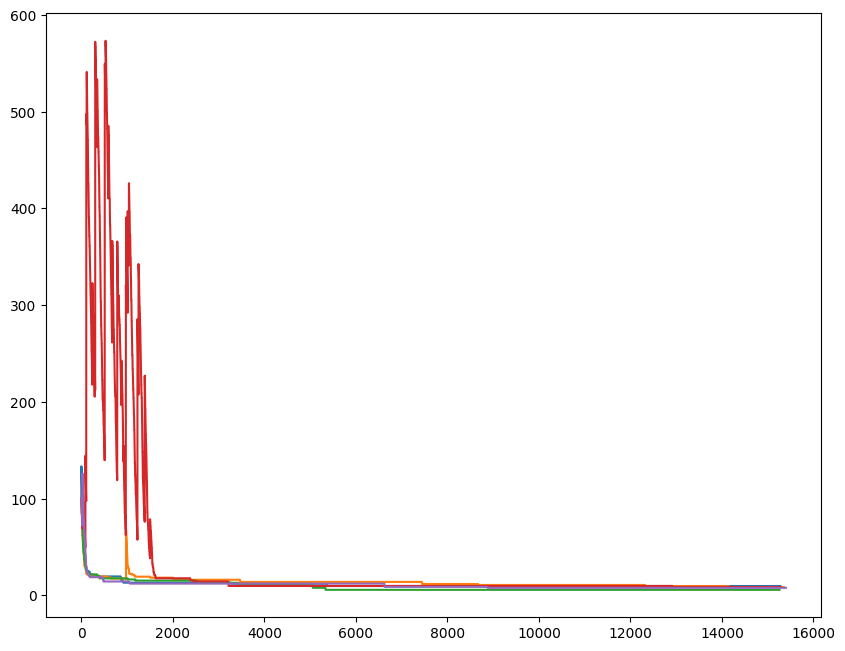

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

plt.figure(figsize=(10,8), dpi=100)
for training, testing in getCrossVal(main, 5):
    model = GradientBoostingRegressor()
    X_train = training[FEATURES]
    y_train = training
    X_test = testing[FEATURES]
    y_test = testing

    n = makeBets_2(model, X_train, y_train, testing, X_test, y_test, TARGET, betSize=5)
    plt.plot(n)
plt.show()